# Glassdoor Salaries

## Salary Prediction Model

WIP

## Model setup

We need to import all the modules we'll be using from numpy, scipy, and keras:

In [1]:
import matplotlib.pyplot as plt

from numpy.random import random, permutation
from scipy import misc, ndimage
from scipy.ndimage.interpolation import zoom
from scipy.io import mmread
from scipy.sparse import coo_matrix, csr_matrix
import numpy as np
import math
import csv

from keras import backend as K
import keras
import json
from keras import backend as K
from keras.utils.data_utils import get_file
from keras.models import Sequential, Model
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.layers import Input
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.optimizers import SGD, RMSprop
from keras.preprocessing import image

Using Theano backend.
Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5103)
/home/ubuntu/anaconda2/lib/python2.7/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)


In [2]:
%pwd
%matplotlib inline

Define Location of data directory and load training matrix into sparse matrix.


In [3]:
data_dir = '/home/ubuntu/full'
sparse_training_matrix = mmread('%s/training-matrix.txt' % data_dir)
print "Done"

Done


- sparse matrix text = training row + " " + column (where value is +1)

Notes:

'''
a.todense() or a.M - Return a dense matrix representation of this matrix. (numpy.matrix)
a.A - Return a dense ndarray representation of this matrix. (numpy.array)
'''


In [ ]:
print sparse_training_matrix.shape
print sparse_training_matrix.getrow(568370)
#print coo_matrix(sparse_training_matrix.getrow(568370), dtype=np.bool)
print "Done"

In [4]:
def salaryToTarget(salary):
    return int(round((max((min((salary * 1.0, 595000.0)), 15000))-15000) / 5000, 0)) + 1

def targetToSalary(target):
    return ((target - 1) * 5000) + 15000

def logSalaryToTarget(logSalary):
    return salaryToTarget(math.pow(math.e, logSalary))

print salaryToTarget(15000)
print salaryToTarget(25000)
print salaryToTarget(2500000)
print targetToSalary(8)
print logSalaryToTarget(10.3089859934221)

salaries = np.zeros((6516817, 118), dtype=np.bool)

with open('%s/log-salaries-truncated.csv' % data_dir,'r') as dest_f:
    data_iter = csv.reader(dest_f)
    for row in data_iter:
        x_index = int(row[0])
        if x_index < 6516817:
            salaries[x_index][logSalaryToTarget(float(row[1]))] = True 
    
print "Created salaries"
    
#targets = mmread('%s/training-matrix.txt' % data_dir)

1
3
117
50000
4
Created salaries


## Model creation

### Features

- Binary vector of length 1812571 
- Each row is a 

### Training Data

- Log salary
- Salaries: $15K => $600K
- Divide into classes of $5K ranges => 117 classes

### Targets

- 118 length vector
- Note: 0 should be ignored


In [5]:
def ConvBlock(layers, model, filters):
    for i in range(layers): 
        model.add(ZeroPadding2D((1,1)))
        model.add(Convolution2D(filters, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

...and here's the fully-connected definition.

In [ ]:
def FCBlock(model):
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))

Define the model

In [11]:
def PhillipSalary1():
    model = Sequential()
    
    model.add(Dense(118, input_shape=(1812571,)))
    # todo this is definitely not correct
    #ConvBlock(3, model, 128)
    #model.add(Flatten())
    #FCBlock(model)
    #FCBlock(model)
    model.add(Dense(118, activation='softmax'))
    return model

We'll learn about what these different blocks do later in the course. For now, it's enough to know that:

- Convolution layers are for finding patterns in images
- Dense (fully connected) layers are for combining patterns across an image

Now that we've defined the architecture, we can create the model like any python object:

As well as the architecture, we need the weights that the VGG creators trained. The weights are the part of the model that is learnt from the data, whereas the architecture is pre-defined based on the nature of the problem. 

Downloading pre-trained weights is much preferred to training the model ourselves, since otherwise we would have to download the entire Imagenet archive, and train the model for many days! It's very helpful when researchers release their weights, as they did here.

In [12]:
try:
    del model
except NameError:
    pass
    
#K.clear_session()

    
model = PhillipSalary1()

In [13]:
lr = 0.1

In [14]:
model.compile(optimizer=SGD(lr=lr), loss='categorical_crossentropy', metrics=['accuracy'])

In [25]:
model.save_weights("model.h5")

In [27]:
csr_sparse_training_matrix = csr_matrix(sparse_training_matrix, dtype=np.bool)

for n in range(2,20):
    
    test_y = salaries[(100*n):(100*(n+1))]
    #print "Finished Salary Matrix: "
    #print test_y

    #test_x = [] 
    test_x = csr_sparse_training_matrix[(100*n):(100*(n+1))].todense()

    #print "Finished CSR Training Matrix"

    #print test_x
    #test_x_a = test_x.A

    #test_x.shape
    #for n in range(10)
    #print "Training Set:     %s" % len(test_x_a)

    #print "Training targets: %s" % len(test_y)

    #print "Features:         %s" % len(test_x_a[0])

    #y = np.zeros(118, dtype=np.int32)
    #y[18] = 1
    #y
    history = model.fit(x=test_x, y=test_y, shuffle="batch")
    print history

Epoch 1/10
100/100 [==============================] - 2s - loss: 1.8418 - acc: 0.5600     
Epoch 2/10
100/100 [==============================] - 1s - loss: 1.7871 - acc: 0.5400     
Epoch 3/10
100/100 [==============================] - 1s - loss: 1.7460 - acc: 0.6400     
Epoch 4/10
100/100 [==============================] - 1s - loss: 1.6895 - acc: 0.6300     
Epoch 5/10
100/100 [==============================] - 1s - loss: 1.6492 - acc: 0.6100     
Epoch 6/10
100/100 [==============================] - 1s - loss: 1.5996 - acc: 0.6800     
Epoch 7/10
100/100 [==============================] - 1s - loss: 1.5588 - acc: 0.6400     
Epoch 8/10
100/100 [==============================] - 1s - loss: 1.5111 - acc: 0.7000     
Epoch 9/10
100/100 [==============================] - 1s - loss: 1.4740 - acc: 0.7100     
Epoch 10/10
100/100 [==============================] - 1s - loss: 1.4280 - acc: 0.7400     
Epoch 1/10
100/100 [==============================] - 1s - loss: 3.1152 - acc: 0.0800    

In [23]:
#history = model.fit(x=test_x, y=test_y, shuffle="batch")

Epoch 1/10
100/100 [==============================] - 2s - loss: 2.3948 - acc: 0.3100     
Epoch 2/10
100/100 [==============================] - 1s - loss: 2.3287 - acc: 0.2600     
Epoch 3/10
100/100 [==============================] - 1s - loss: 2.2695 - acc: 0.3000     
Epoch 4/10
100/100 [==============================] - 1s - loss: 2.2128 - acc: 0.3500     
Epoch 5/10
100/100 [==============================] - 1s - loss: 2.1477 - acc: 0.4000     
Epoch 6/10
100/100 [==============================] - 1s - loss: 2.0995 - acc: 0.4000     
Epoch 7/10
100/100 [==============================] - 1s - loss: 2.0439 - acc: 0.4200     
Epoch 8/10
100/100 [==============================] - 1s - loss: 1.9909 - acc: 0.4500     
Epoch 9/10
100/100 [==============================] - 1s - loss: 1.9366 - acc: 0.4700     
Epoch 10/10
100/100 [==============================] - 1s - loss: 1.8918 - acc: 0.5400     


['acc', 'loss']


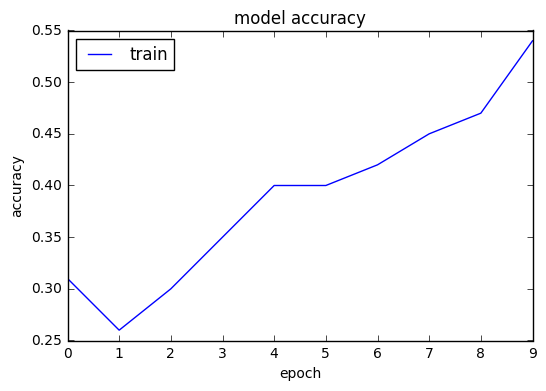

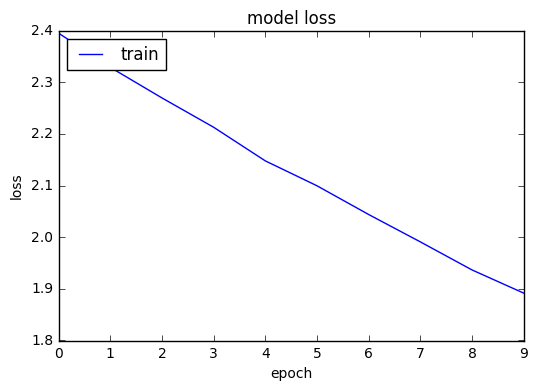

In [24]:
# list all data in history
print(history.history.keys())

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()